In [2]:
import gym
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import csv
import random

class Actor(nn.Module):
    def __init__(self, state_shape, action_dim):
        super().__init__()

        hidden_size = 256

        self.dense_1 = nn.Linear(state_shape, hidden_size)
        self.dense_2 = nn.Linear(hidden_size, hidden_size)
        self.dense_3 = nn.Linear(hidden_size, action_dim)

    def forward(self, x):
        x = F.relu(self.dense_1(x))
        x = F.relu(self.dense_2(x))
        x = torch.tanh(self.dense_3(x))
        return x

class Critic(nn.Module):
    def __init__(self, state_shape, action_dim):
        super().__init__()

        hidden_size = 256

        self.dense_1 = nn.Linear(state_shape + action_dim, hidden_size)
        self.dense_2 = nn.Linear(hidden_size, hidden_size)
        self.dense_3 = nn.Linear(hidden_size, 1)

        self.dense_4 = nn.Linear(state_shape + action_dim, hidden_size)
        self.dense_5 = nn.Linear(hidden_size, hidden_size)
        self.dense_6 = nn.Linear(hidden_size, 1)

    def forward(self, x, x_actions):
        x = torch.cat([x, x_actions], dim=1)

        q1 = F.relu(self.dense_1(x))
        q1 = F.relu(self.dense_2(q1))
        q1 = self.dense_3(q1)

        q2 = F.relu(self.dense_4(x))
        q2 = F.relu(self.dense_5(q2))
        q2 = self.dense_6(q2)

        return q1, q2

    def forward_q1(self, x, x_actions):
        x = torch.cat([x, x_actions], dim=1)
        x = F.relu(self.dense_1(x))
        x = F.relu(self.dense_2(x))
        x = self.dense_3(x)
        return x

class ReplayBuffer:
    def __init__(self, max_len, state_shape, action_dim, device):
        self.device = device

        self.max_len = max_len

        self.state_buffer = torch.zeros((max_len, state_shape), dtype=torch.float32).to(device)
        self.action_buffer = torch.zeros((max_len, action_dim), dtype=torch.float32).to(device)
        self.reward_buffer = torch.zeros(max_len, dtype=torch.float32).to(device)
        self.next_state_buffer = torch.zeros((max_len, state_shape), dtype=torch.float32).to(device)
        self.done_buffer = torch.zeros(max_len, dtype=torch.float32).to(device)

        self.ptr = 0

        self.size = 0

    def __len__(self):
        return self.size

    def append(self, state, action, reward, next_state, done):
        self.state_buffer[self.ptr] = torch.tensor(state).to(self.device)
        self.action_buffer[self.ptr] = torch.tensor(action).to(self.device)
        self.reward_buffer[self.ptr] = torch.tensor(reward).to(self.device)
        self.next_state_buffer[self.ptr] = torch.tensor(next_state).to(self.device)
        self.done_buffer[self.ptr] = torch.tensor(done).to(self.device)

        self.ptr = (self.ptr + 1) % self.max_len
        self.size = min(self.size + 1, self.max_len)

    def sample(self, batch_size):
        indices = np.random.randint(0, self.size, size=batch_size)
        states = self.state_buffer[indices]
        actions = self.action_buffer[indices]
        rewards = self.reward_buffer[indices]
        next_states = self.next_state_buffer[indices]
        dones = self.done_buffer[indices]
        return states, actions, rewards, next_states, dones

class GaussianNoiseGenerator:
    def __init__(self, sigma=0.1):
        self.sigma = sigma

    def sample(self, *args):
        return self.sigma * np.random.randn(*args)

class Logger:
    def __init__(self, csv_filename="episode_rewards.csv"):
        self.episodes = 0
        self.total_steps = 0
        self.new_line_every = 25000
        self.cumulative_reward = 0
        self.current_episode_length = 0
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_rewards_ma = 0
        self.episode_lengths_ma = 0
        self.csv_filename = csv_filename

    def log(self, reward, done):
        self.cumulative_reward += reward
        self.current_episode_length += 1

        if done:
            self.episode_rewards.append(self.cumulative_reward)
            self.episode_lengths.append(self.current_episode_length)
            self.episode_rewards_ma = np.mean(self.episode_rewards[-50:])
            self.episode_lengths_ma = np.mean(self.episode_lengths[-50:])
            self.episodes += 1

            self.cumulative_reward = 0
            self.current_episode_length = 0

        self.total_steps += 1

    def write_to_csv(self):
        with open(self.csv_filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Episode", "Total Steps", "Episode Reward", "Episode Length"])
            for i in range(len(self.episode_rewards)):
                writer.writerow([i + 1, (i + 1) * self.episode_lengths[i], self.episode_rewards[i], self.episode_lengths[i]])

    def print_logs(self):
        end_char = "\n" if self.total_steps % self.new_line_every == 0 else "\r"
        print(f"Episode: {self.episodes} | Avg reward per episode: {self.episode_rewards_ma:.4f} | Avg steps per episode: {self.episode_lengths_ma:.2f}", end=end_char)

config = {
    'learning_rate_actor': 0.001,
    'learning_rate_critic': 0.001,
    'tau': 0.005,
    'buffer_max_length': 500000,
    'batch_size': 256,
    'start_timesteps': 10000,
    'updates_per_step': 1,
    'policy_freq': 2,
    'gamma': 0.99,
    'sigma': 0.2,
    'clip_noise': 0.5,
    'action_low': -1,
    'action_high': 1
}

class TD3Agent:
    def __init__(self, env, Actor, Critic, config):
        self.env = env

        self.state_shape = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.shape[0]
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.actor = Actor(self.state_shape, self.action_dim).to(self.device)
        self.critic = Critic(self.state_shape, self.action_dim).to(self.device)

        self.actor_target = Actor(self.state_shape, self.action_dim).to(self.device)
        self.critic_target = Critic(self.state_shape, self.action_dim).to(self.device)

        self.learning_rate_actor = config['learning_rate_actor']
        self.learning_rate_critic = config['learning_rate_critic']
        self.tau = config['tau']
        self.buffer_max_length = config['buffer_max_length']
        self.batch_size = config['batch_size']
        self.start_timesteps = config['start_timesteps']
        self.updates_per_step = config['updates_per_step']
        self.policy_freq = config['policy_freq']
        self.gamma = config['gamma']
        self.sigma = config['sigma']
        self.clip_noise = config['clip_noise']
        self.action_low = config['action_low']
        self.action_high = config['action_high']

        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr=self.learning_rate_actor)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr=self.learning_rate_critic)

        self.buffer = ReplayBuffer(self.buffer_max_length, self.state_shape, self.action_dim, self.device)

        self.gaussian_noise = GaussianNoiseGenerator(self.sigma)

        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.logger = Logger()

    def train(self, max_timesteps):
        state = self.env.reset()

        for current_timestep in range(max_timesteps):
            if len(self.buffer) < self.start_timesteps:
                action = self.env.action_space.sample()
            else:
                action = self.act(state)
                noise = self.gaussian_noise.sample(self.action_dim)
                action = np.clip(action + noise, a_min=self.action_low, a_max=self.action_high)

            step_output = self.env.step(action)
            if len(step_output) == 4:
                next_state, reward, done, info = step_output
                truncated = False
            else:
                next_state, reward, terminated, truncated, info = step_output
                done = terminated or truncated

            self.buffer.append(state, action, reward, next_state, done)

            self.logger.log(reward, done)
            self.logger.print_logs()

            if done:
                state = self.env.reset()
            else:
                state = next_state

            if current_timestep < self.start_timesteps:
                continue

            states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)

            with torch.no_grad():
                noise = torch.tensor(self.gaussian_noise.sample(self.batch_size, self.action_dim), dtype=torch.float, device=self.device).clip(-self.clip_noise, self.clip_noise)
                next_actions = torch.clip(self.actor_target(next_states) + noise, min=self.action_low, max=self.action_high)
                targets_q1, targets_q2 = self.critic(next_states, next_actions)
                targets_q = torch.min(targets_q1, targets_q2).squeeze(-1)
                targets_q = rewards + self.gamma * (1 - dones) * targets_q

            pred_q1, pred_q2 = self.critic(states, actions)
            loss_critic = F.mse_loss(pred_q1.squeeze(-1), targets_q) + F.mse_loss(pred_q2.squeeze(-1), targets_q)

            self.optimizer_critic.zero_grad()
            loss_critic.backward()
            self.optimizer_critic.step()

            if current_timestep % self.policy_freq == 0:
                loss_actor = -self.critic.forward_q1(states, self.actor(states)).mean()

                self.optimizer_actor.zero_grad()
                loss_actor.backward()
                self.optimizer_actor.step()

                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        self.logger.write_to_csv()

    def act(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float, device=self.device)
        with torch.no_grad():
            return self.actor(state_tensor).detach().cpu().numpy()

class ObservationScalingWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)

    def observation(self, observation):
        observation[0] *= 1. / 3.14
        observation[1] *= 0.2
        observation[2] *= 0.2
        observation[3] *= 0.2
        observation[4] *= 1. / 3.14
        observation[5] *= 0.2
        observation[6] *= 1.0 / 3.14
        observation[7] *= 0.2
        observation[8] *= 0.2
        observation[9] *= 1. / 3.14
        observation[10] *= 0.2
        observation[11] *= 1. / 3.142
        observation[12] *= 0.2
        observation[13] *= 0.2
        return observation

class RewardScalingWrapper(gym.RewardWrapper):
    def __init__(self, env, scaling_factor=1./5):
        super().__init__(env)
        self.scaling_factor = scaling_factor

    def reward(self, reward):
        return reward * self.scaling_factor

config['batch_size'] = 128
config['learning_rate_critic'] = 0.0001
config['learning_rate_actor'] = 0.0001

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
env = gym.make('BipedalWalker-v3')
env.seed(seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)
env = RewardScalingWrapper(ObservationScalingWrapper(env))

# Set deterministic algorithms for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

agent_walker = TD3Agent(env, Actor, Critic, config)
agent_walker.train(500000)

agent_walker.logger.episode_rewards = [r * 5 for r in agent_walker.logger.episode_rewards]


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


Episode: 62 | Avg reward per episode: -21.9982 | Avg steps per episode: 400.14
Episode: 85 | Avg reward per episode: -18.3509 | Avg steps per episode: 750.40
Episode: 105 | Avg reward per episode: -14.7098 | Avg steps per episode: 1131.64
Episode: 125 | Avg reward per episode: -13.6004 | Avg steps per episode: 1190.40
Episode: 141 | Avg reward per episode: -13.3819 | Avg steps per episode: 1338.90
Episode: 161 | Avg reward per episode: -9.1745 | Avg steps per episode: 1318.12
Episode: 179 | Avg reward per episode: -2.6629 | Avg steps per episode: 1355.12
Episode: 198 | Avg reward per episode: 7.1350 | Avg steps per episode: 1327.10
Episode: 215 | Avg reward per episode: 14.3994 | Avg steps per episode: 1351.76
Episode: 252 | Avg reward per episode: 1.7828 | Avg steps per episode: 910.88
Episode: 273 | Avg reward per episode: 1.5120 | Avg steps per episode: 921.06
Episode: 290 | Avg reward per episode: 17.2722 | Avg steps per episode: 1206.90
Episode: 306 | Avg reward per episode: 32.49

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

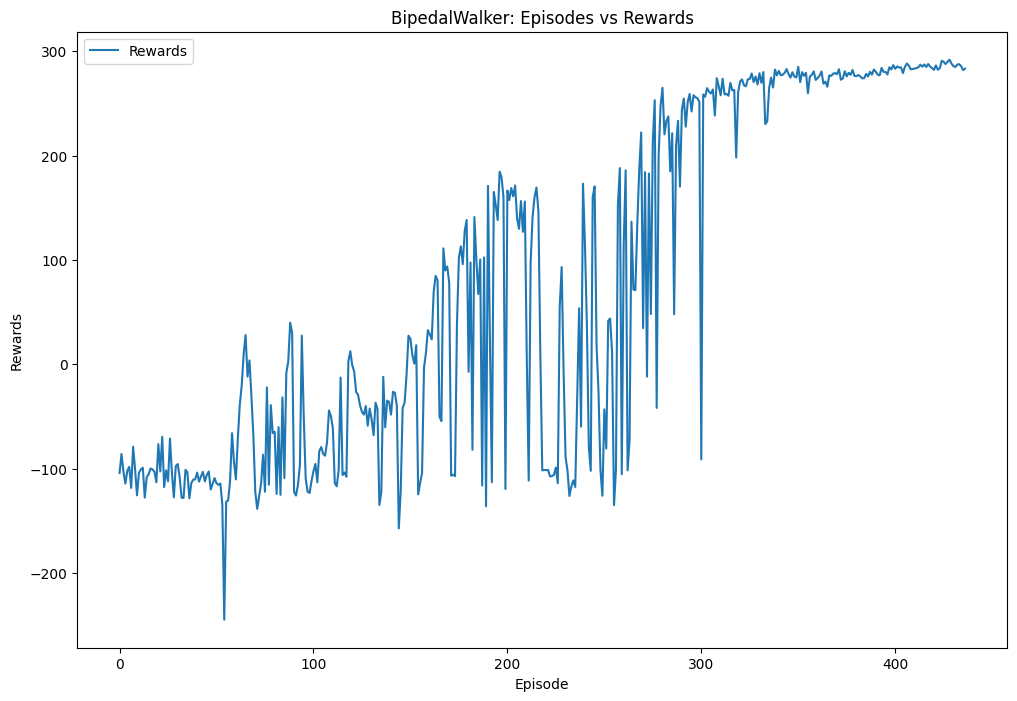

CSV file saved as 'episode_rewards.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to plot training progress and save rewards to CSV
def plot_training(logger, title=""):
    episodes = np.arange(len(logger.episode_rewards))
    rewards = logger.episode_rewards

    # Print statements for debugging
    print(episodes)
    print(rewards)

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.plot(episodes, rewards, label='Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.title(title)
    plt.legend()
    plt.show()

    # Create a DataFrame and save it to CSV
    data = {'Episode': episodes, 'Rewards': rewards}
    df = pd.DataFrame(data)
    df.to_csv('episode_rewards.csv', index=False)
    print("CSV file saved as 'episode_rewards.csv'")

plot_training(agent_walker.logger, title="BipedalWalker: Episodes vs Rewards")


from google.colab import files
files.download('episode_rewards.csv')
